#### Finetuning ViT baseline from HuggingFace for Office31 Dataset Classification

In [40]:
from datasets import load_dataset, load_metric
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
import torchvision.transforms
from torch.utils.data import DataLoader
import torch
import numpy as np


In [5]:
# Loading the Office31 dataset with the HuggingFace dataset loader
ds = load_dataset('imagefolder', data_dir="../examples/data/domain_adaptation_images/amazon/images", split='train')
splits = ds.train_test_split(test_size=0.15)
train_ds = splits['train']
val_ds = splits['test']

Resolving data files:   0%|          | 0/2817 [00:00<?, ?it/s]

Using custom data configuration default-b517851761daecc6
Reusing dataset image_folder (/Users/aldozaimi/.cache/huggingface/datasets/image_folder/default-b517851761daecc6/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


In [36]:
# Checking the dataset structure and classes
print(train_ds)
print(train_ds.features)

Dataset({
    features: ['image', 'label'],
    num_rows: 2394
})
{'image': Image(decode=True, id=None), 'label': ClassLabel(num_classes=31, names=['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can'], id=None)}


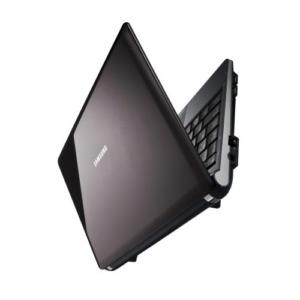

In [11]:
# Playing with a sample dataset to check image
train_ds[0]['image']

In [12]:
# Switching between labels and images
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label[train_ds[0]['label']]

'laptop_computer'

In [16]:
# Using the ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [18]:
# Defining data aug. transforms

_train_transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(feature_extractor.size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ]
    )

_val_transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(feature_extractor.size),
            torchvision.transforms.CenterCrop(feature_extractor.size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples



In [19]:
# Applying the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [26]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=8)


In [28]:
# To test the data loader

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([8, 3, 224, 224])
labels torch.Size([8])


In [37]:
# Loading the pretrained baseline
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=train_ds.features['label'].num_classes,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Defining the training arguments

args = TrainingArguments(
    f"test-office31-vit",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

In [41]:
# Defining the metrics

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [42]:
# Defining the Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [43]:
# Training the model
trainer.train()

/opt/homebrew/Caskroom/miniforge/base/envs/simulation_venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2394
  Num Epochs = 2
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 480
Trainer is attempting to log a value of "{0: 'back_pack', 1: 'bike', 2: 'bike_helmet', 3: 'bookcase', 4: 'bottle', 5: 'calculator', 6: 'desk_chair', 7: 'desk_lamp', 8: 'desktop_computer', 9: 'file_cabinet', 10: 'headphones', 11: 'keyboard', 12: 'laptop_computer', 13: 'letter_tray', 14: 'mobile_phone', 15: 'monitor', 16: 'mouse', 17: 'mug', 18: 'paper_notebook', 19: 'pen', 20: 'phone', 21: 'p

  0%|          | 0/480 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 423
  Batch size = 4


  0%|          | 0/106 [00:00<?, ?it/s]

Saving model checkpoint to test-office31-vit/checkpoint-240
Configuration saved in test-office31-vit/checkpoint-240/config.json


{'eval_loss': 2.83489727973938, 'eval_accuracy': 0.7943262411347518, 'eval_runtime': 30.7208, 'eval_samples_per_second': 13.769, 'eval_steps_per_second': 3.45, 'epoch': 1.0}


Model weights saved in test-office31-vit/checkpoint-240/pytorch_model.bin
Feature extractor saved in test-office31-vit/checkpoint-240/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 423
  Batch size = 4


  0%|          | 0/106 [00:00<?, ?it/s]

Saving model checkpoint to test-office31-vit/checkpoint-480
Configuration saved in test-office31-vit/checkpoint-480/config.json
Model weights saved in test-office31-vit/checkpoint-480/pytorch_model.bin
Feature extractor saved in test-office31-vit/checkpoint-480/preprocessor_config.json


{'eval_loss': 2.622290849685669, 'eval_accuracy': 0.7990543735224587, 'eval_runtime': 30.5366, 'eval_samples_per_second': 13.852, 'eval_steps_per_second': 3.471, 'epoch': 2.0}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from test-office31-vit/checkpoint-480 (score: 0.7990543735224587).


{'train_runtime': 850.1413, 'train_samples_per_second': 5.632, 'train_steps_per_second': 0.565, 'train_loss': 2.922399139404297, 'epoch': 2.0}


TrainOutput(global_step=480, training_loss=2.922399139404297, metrics={'train_runtime': 850.1413, 'train_samples_per_second': 5.632, 'train_steps_per_second': 0.565, 'train_loss': 2.922399139404297, 'epoch': 2.0})

In [44]:
# Evaluation
outputs = trainer.predict(val_ds)
print(outputs.metrics)

***** Running Prediction *****
  Num examples = 423
  Batch size = 4


  0%|          | 0/106 [00:00<?, ?it/s]

{'test_loss': 2.622290849685669, 'test_accuracy': 0.7990543735224587, 'test_runtime': 31.8939, 'test_samples_per_second': 13.263, 'test_steps_per_second': 3.324}


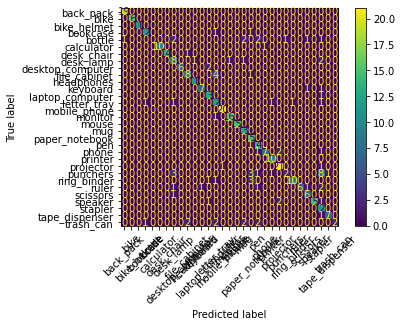

In [45]:
# Visualizing classification results with confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)